In [1]:
import numpy as np
import scipy as sp
import corner
import multiprocessing

from iminuit import Minuit

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from mcmc import metropolis_hastings
from plot import plot_2d_pdf_contour

np.random.seed(1)

# 0.1 MC events and data

In [2]:
mc_bkg = np.loadtxt('mc_background.txt')
mc_sig = np.loadtxt('mc_signal.txt')
data = np.loadtxt('LHC_data.txt')

bins = np.linspace(100, 160, 50)

bkg_counts,  bins = np.histogram(mc_bkg, bins=bins)
sig_counts,  bins = np.histogram(mc_sig, bins=bins)
data_counts, bins = np.histogram(data, bins=bins)

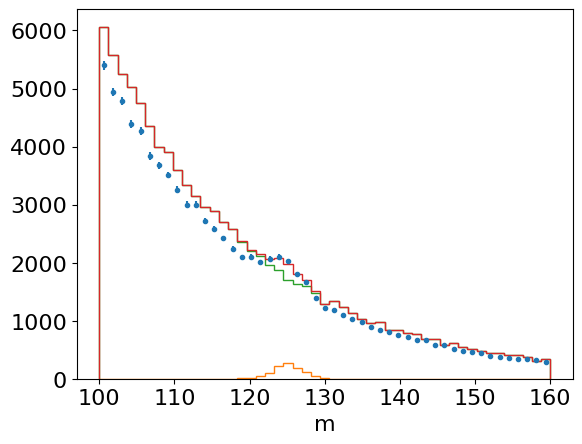

In [3]:
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, data_counts, np.sqrt(data_counts), fmt='.')
plt.stairs(sig_counts, bins)
plt.stairs(bkg_counts, bins)
plt.stairs(sig_counts+bkg_counts, bins)
plt.xlabel('m')
plt.show()

# 0.2 Likelihood function

In [4]:
def negative_log_likelihood(mu, mu_bkg, sig, bkg, data):
    '''
    -2*log(p(data|theta))
    '''
    return -2*np.sum(sp.stats.poisson.logpmf(data, mu*sig+mu_bkg*bkg))

# 1. Priors

We use a flat prior for $\mu$ and a normal prior for $\mu_{bkg}$.

In [5]:
def negative_log_prior(mu, mu_bkg):
    '''
    -2*log(p(theta))
    '''
    p_mu = 0 if 0 <= mu <= 5 else np.inf
    b_exp = 1
    sigma_b = 0.5
    p_mu_bkg = ((mu_bkg-b_exp)/sigma_b)**2
    return p_mu+p_mu_bkg

# 2. Posterior

In [6]:
def negative_log_posterior(mu, mu_bkg, sig, bkg, data):
    '''
    -2*log(p(theta|data))
    '''
    return negative_log_likelihood(mu, mu_bkg, sig, bkg, data) + negative_log_prior(mu, mu_bkg)

# 3. Mode and prior impact

In [7]:
nll_unconstrained = lambda mu, mu_bkg: negative_log_likelihood(mu, mu_bkg, sig_counts, bkg_counts, data_counts)

m = Minuit(nll_unconstrained, 1,1, name=(r'mu', r'mu_bkg'))
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 518.1                      │              Nfcn = 53               │
│ EDM = 2.97e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu     │   1.93    │   0.11    │            │            │         │         │       │
│ 1 │ mu_bkg │  0.9017   │  0.0033   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │        mu    mu_bkg │
├────────┼─────────────────────┤
│     mu │    0.0119 -0.105e-3 │
│ mu_bkg │ -0.105e-3  1.06e-05 │
└────────┴─────────────────────┘

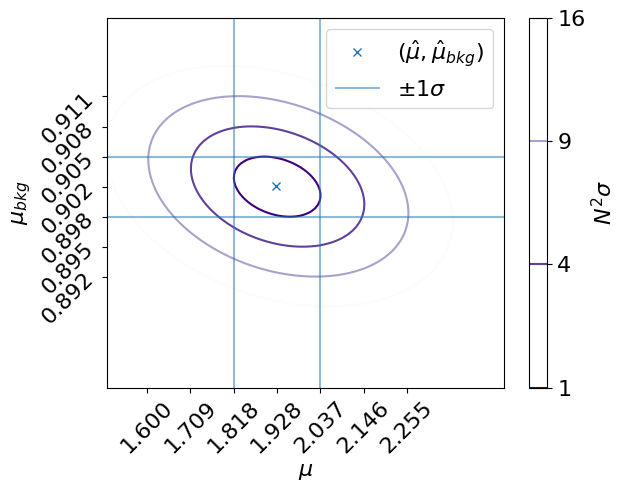

In [8]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nll_unconstrained,
    x_range=(1.5, 2.5),
    y_range=(0.88, 0.92),
    resolution=100,
    x_sigma=sigmax,
    y_sigma=sigmay,
    x_label=r'$\mu$',
    y_label=r'$\mu_{bkg}$',
    mode_label=r'$(\hat \mu, \hat \mu_{bkg})$',
    )

In [9]:
nl_posterior = lambda mu, mu_bkg: negative_log_posterior(mu, mu_bkg, sig_counts, bkg_counts, data_counts)

m = Minuit(nl_posterior, 1,1, name=(r'mu', r'mu_bkg'))
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 518.1                      │              Nfcn = 53               │
│ EDM = 2.97e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu     │   1.93    │   0.11    │            │            │         │         │       │
│ 1 │ mu_bkg │  0.9017   │  0.0033   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │        mu    mu_bkg │
├────────┼─────────────────────┤
│     mu │    0.0119 -0.105e-3 │
│ mu_bkg │ -0.105e-3  1.06e-05 │
└────────┴─────────────────────┘

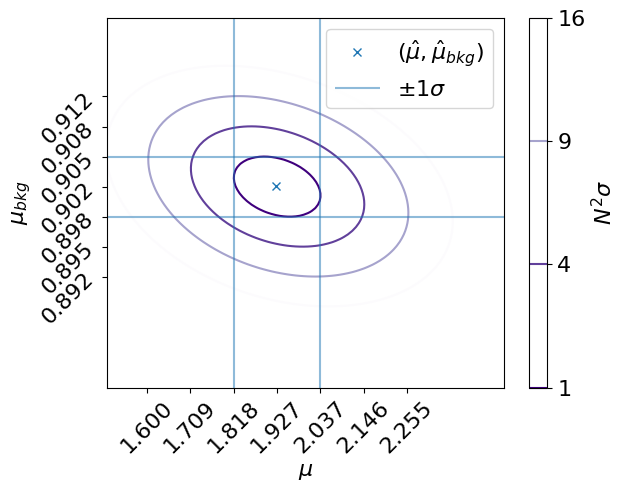

In [10]:
sigmax = [m.values[0], m.errors[0]]
sigmay = [m.values[1], m.errors[1]]

plot_2d_pdf_contour(
    nl_posterior,
    x_range=(1.5, 2.5),
    y_range=(0.88, 0.92),
    resolution=100,
    x_sigma=sigmax,
    y_sigma=sigmay,
    x_label=r'$\mu$',
    y_label=r'$\mu_{bkg}$',
    mode_label=r'$(\hat \mu, \hat \mu_{bkg})$',
    )

# 4. Metropolis hastings

We will copy the implementation from [here](./mcmc.py).

# 5. Posterior samples

We generate samples from the posterior, in independent 8 chains.

In [11]:
iterations = 100000
chains = 8

nlpost = lambda pars: negative_log_posterior(*pars, sig_counts, bkg_counts, data_counts)

# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 3), np.random.uniform(0, 3)] for _ in range(chains)
]

# Run chains in parallel
def run_chain(initial_point):
    chain = metropolis_hastings(nlpost, iterations, initial_point)
    return chain

with multiprocessing.Pool(processes=chains) as pool:
    chains = pool.map(run_chain, initial_points)

samples = np.vstack(chains)

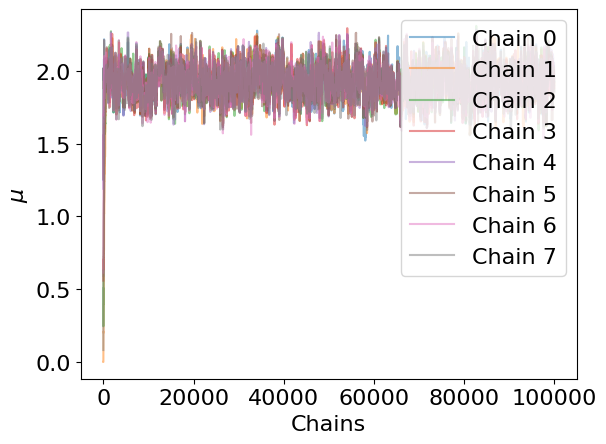

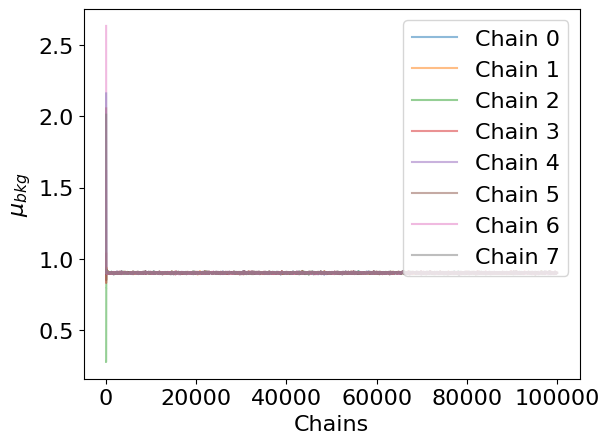

In [12]:
for i,c in enumerate(chains):
    plt.plot(c[:,0], alpha=0.5, label=f'Chain {i}')

plt.xlabel('Chains')
plt.ylabel(r'$\mu$')
plt.legend(loc='upper right')
plt.show()

for i,c in enumerate(chains):
    plt.plot(c[:,1], alpha=0.5, label=f'Chain {i}')

plt.xlabel('Chains')
plt.ylabel(r'$\mu_{bkg}$')
plt.legend(loc='upper right')
plt.show()

# 6. Full and marginal posterior

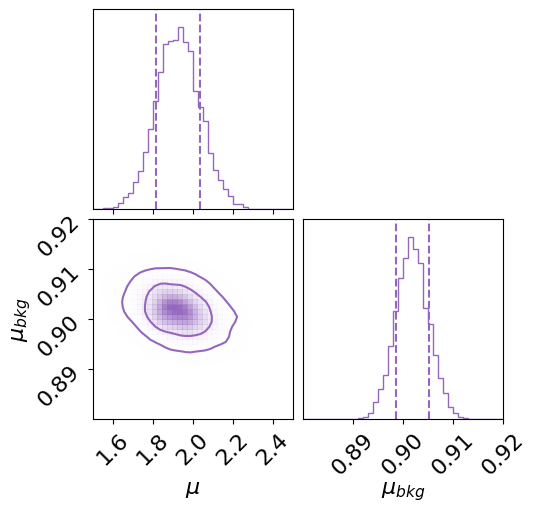

In [13]:
fig = corner.corner(
    samples,
    bins=40,
    range=[(1.5,2.5), (0.88, 0.92)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\mu$', r'$\mu_{bkg}$'],
    color='tab:purple',
    );

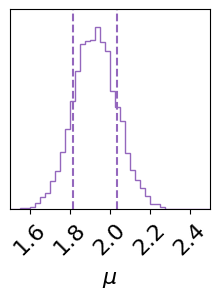

In [14]:
fig = corner.corner(
    samples[:,0],
    bins=40,
    range=[(1.5,2.5)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$\mu$'],
    color='tab:purple',
    );

# 7. Upper 95% credible interval

In [20]:
def credible_interval(samples, level):
    nsamples = len(samples)
    return float(np.sort(samples)[int(level*nsamples)])

In [31]:
print(f'95% upper CI: {credible_interval(samples[:,0], 0.05):.3f}')

95% upper CI: 1.745


# 8. Central intervals

# $\mu$

In [34]:
print(f'68% central CI: {credible_interval(samples[:,0], 0.160):.3f}, {credible_interval(samples[:,0], 0.840):.3f}')
print(f'95% central CI: {credible_interval(samples[:,0], 0.025):.3f}, {credible_interval(samples[:,0], 0.975):.3f}')

68% central CI: 1.817, 2.035
95% central CI: 1.707, 2.146


# $\mu_{bkg}$

In [35]:
print(f'68% central CI: {credible_interval(samples[:,1], 0.160):.3f}, {credible_interval(samples[:,1], 0.840):.3f}')
print(f'95% central CI: {credible_interval(samples[:,1], 0.025):.3f}, {credible_interval(samples[:,1], 0.975):.3f}')

68% central CI: 0.899, 0.905
95% central CI: 0.895, 0.908
